# Test Notebook for nisarcryodb
---

This note book is used to develop, test, and document the  `nisarcryodb` class, which is used to query the NISAR cal/val db for GPS data from cryosphere validation sites.


In [18]:
%load_ext autoreload
%autoreload 2
import nisarcryodb
from psycopg2 import sql
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialize nisarcryodb Object

This step initializes the connection to the nisar cal/val data base. It requires a cal/val database user name and passwd.

In [19]:
myConnection = nisarcryodb.nisarcryodb()

User name:  irj
Password:  ········


## List Schema

List all of the schema in the database. 

In [20]:
schemas = myConnection.listSchema(quiet=False)

pg_catalog
information_schema
soil_moisture
pg_temp_7
pg_toast_temp_7
pg_temp_8
pg_toast_temp_8
disturbance
corner_reflectors
landice
solidearth
crop_area
inundation
pg_temp_16
pg_toast_temp_16
biomass
seaice
nisar
permafrost
tiger
tiger_data
topology
public


## List Table Names for Schema

List the names of the table under the landice schema.

In [21]:
myConnection.listSchemaTableNames('landice');

requirement
site
gps_data
gps_data_version
l3_product
gps_test_data
l3_product_calval_site_jct
l3_product_requirement_jct
validation_run
validation_run_gps_data_jct
velocity_data
gps_station


## List Column Names for Table

List the column names for a table (e.g., gps_station) and schema (e.g., landice).

In [22]:
stationColumns = myConnection.listTableColumns('landice', 'gps_station', quiet=False)

station_id, station_name, reflat, reflon, refheight, poc_name, poc_email, station_geom, site_id


This time get the columns for the gps_data table. Use `returnType=True` to get the data type for each column.

In [23]:
gpsColumns, gpsDataTypes = myConnection.listTableColumns('landice', 'gps_data', returnType=True)

gps_data_id, station_id, version_id, date_uploaded, measurement_dt_utc, decimal_year, nominal_doy, lat, lon, ht_abv_eps, sigma_e, sigma_n, sigma_v, data_geom
integer, integer, integer, date, timestamp without time zone, double precision, integer, double precision, double precision, double precision, real, real, real, USER-DEFINED


## List Column Values

Get the `station_name` column values for `landice.gps_station` tables. Select only those that begin with "N".

In [30]:
stationNames = myConnection.getColumn('landice', 'gps_station', 'station_name')
[station for station in stationNames if station.startswith("N")]

['NIU1',
 'NIU2',
 'NIU3',
 'NIU4',
 'NIU5',
 'NIT0',
 'NIT1',
 'NIT2',
 'NIT3',
 'NIT4',
 'NIT5',
 'NIL1',
 'NIL2',
 'NIL3',
 'NIL4',
 'NIL5',
 'NIT7']

Get the `latitude` column values for `landice.gps_data` tables 

In [31]:
lat = myConnection.getColumn('landice', 'gps_data', 'lat');
lat[0:10]

[68.87457898,
 68.87457901,
 68.87457901,
 68.87457895,
 68.87457897,
 68.87457899,
 68.87457895,
 68.87457899,
 68.87457904,
 68.87457906]

## Station Name to ID

Determine the station ID (e.g., 22) from the station name (e.g., LORG).

In [32]:
myConnection.stationNameToID('NIL3')

9

## Get GPS Data for Date Range

Return all the data for a designated station for the decimal date range (d1, d2). 

In [33]:
d1 = 2024.8165544457129-1
d2 = 2025.819178050482+1
myData = myConnection.getStationDateRangeData('NIL3', d1, d2, schemaName='landice', tableName='gps_data')

Text(0, 0.5, 'latitude')

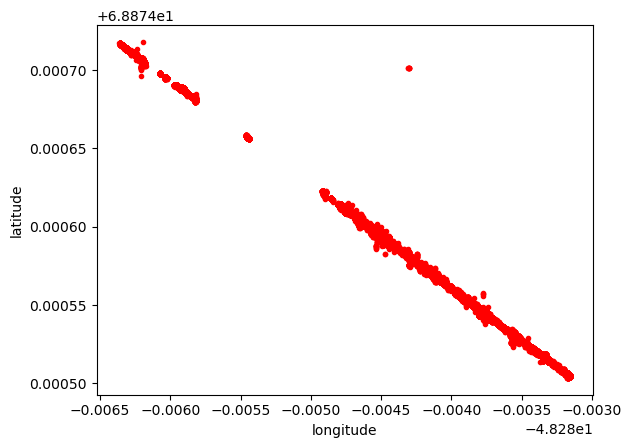

In [34]:
plt.plot(myData['lon'], myData['lat'], 'r.')
plt.xlabel('longitude')
plt.ylabel('latitude')

## Get Station Information

Return the table with all of the top-level station data (e.g,, name, id, position, etc).

In [35]:
myConnection.getTableListing(schemaName='landice', tableName='gps_station')

SELECT * FROM landice.gps_station ;


,station_id,station_name,reflat,reflon,refheight,poc_name,poc_email,station_geom,site_id
0,28,test_station_04,-76.362527,-113.016636,1285.966,None,None,0101000020E61000003303AE8E10415CC0988D08A53317...,3
1,29,test_station_05,-76.529492,-113.321411,1286.713,None,None,0101000020E6100000DF11DBFE91545CC06E60BC30E321...,3
2,30,test_station_06,-76.696124,-113.633897,1282.002,None,None,0101000020E610000077C45BC691685CC07637EC4A8D2C...,3
3,31,test_station_07,-76.862408,-113.954372,1296.276,None,None,0101000020E6100000C6B3786F147D5CC06A1AD2B03137...,3
4,32,test_station_08,-75.758186,-111.185644,851.224,None,None,0101000020E610000078A3A896E1CB5BC00C955E1F86F0...,3
...,...,...,...,...,...,...,...,...,...
70,76,test_station_52,-76.750306,-108.635458,1137.159,None,None,0101000020E61000001188BE58AB285BC05DEB62050530...,3
71,77,test_station_53,-76.922398,-108.892086,1181.641,None,None,0101000020E61000006BED22F117395BC0F97CBD90083B...,3
72,78,test_station_54,-77.094279,-109.155612,1198.846,None,None,0101000020E61000006EE6EB8DF5495BC0F969FDA90846...,3
73,79,test_station_55,-77.265938,-109.426307,1205.697,None,None,0101000020E6100000C963BC9C485B5BC07D6E2E1F0551...,3


## Get Level 3 Products

Get all L3 products from 2015 to 2023. Filters can be specified by column heading and value (e.g., `filters={'measurement_type': 'velocity'}`. Wild can be set off with % signs. For example, to list only the velocity files with 'vx' in the name will be accomplished by `filters={'product_path': '%vx%'}`.

In [36]:
date1 = '01-01-2015'
date2 = '12-31-2023'
myConnection.getL3DateRangeData(date1, date2, schemaName='landice', tableName='l3_product', filters={'product_path': '%vx%', 'measurement_type': 'velocity'})

product_path
measurement_type


,product_id,start_date,end_date,resolution,accuracy,measurement_type,provider,product_type,product_path,product_version,software_version,config_file_path,date_created,archived,location_geom,notes
0,2,2016-12-01,2017-11-30,None,None,velocity,None,test,s3://nisar-st-cryosphere-validation/test/veloc...,None,None,None,None,None,0106000020E61000000100000001030000000100000013...,test
1,5,2017-12-01,2018-11-30,None,None,velocity,None,test,s3://nisar-st-cryosphere-validation/test/veloc...,None,None,None,None,None,0106000020E61000000100000001030000000100000013...,test
2,8,2018-12-01,2019-11-30,None,None,velocity,None,test,s3://nisar-st-cryosphere-validation/test/veloc...,None,None,None,None,None,0106000020E61000000100000001030000000100000013...,test


## Rollback a Query Error

This will reset the connection after a query fails with an error. Most of the routines should trap errors and automatically rollback.

In [37]:
myConnection.connection.rollback()

## Close the connection

Close the connection when finished.

In [38]:
myConnection.close()